# TEF Budget

Demonstration of accurate velocity and salinity extraction for a control volume defined by one or more sections.

Performs water and salt balances, calculating the imbalance (error) and plotting it on a time series. Tidal averaging will reduce the apparent magnitude of the errors by removing the tidal component. Some of this error is irrelevant to the TEF extraction, and is introduced from interpolating $dV/dt$ on a 1-hour interval. I have found that the error reduces quite a bit, from ~60% to 20% of $Q_R$, when a separate hydrodynamic run is made with a 1/2-hour output interval. Velocity extractions must be done against an identical run with the standard 1-hour output interval. The code in this notebook is smart enough to handle the difference in output frequency between the two sets of NetCDF files.

In [1]:
hydro_output_cdf = '/home/benr/wqmodels/ssm/hifreq-hydro-test/OUTPUT/netcdf/ssm_*.nc'
hydro_output_start = '2014-01-01'
rivers_cdf = '../input_files/data/fvcom_riv_2014.nc'
extracts_path = '/home/benr/wqmodels/lo/LiveOcean_output/tef/union1x_test'
section_names = ['HoodCanalEntrance']
run_name = 'union1x_hoodcanal_tideavg'

tide_avg = True

from glob import glob
import os
import os.path as path
from multiprocessing import Pool
import pickle

from netCDF4 import Dataset, MFDataset
import networkx as nx
import numpy as np
from scipy.interpolate import interp1d
from scipy import ndimage
import matplotlib.pyplot as plt
import pandas as pd
from joblib import Memory
from fvcom.grid import FvcomGrid
from fvcom.depth import DepthCoordinate
from fvcom.transect import Transect
from fvcom.control_volume import ControlVolume

# From LiveOcean; add LiveOcean/alpha to conda.pth
from zfun import filt_godin

In [2]:
out_file = lambda name: path.join("notebook_outs", run_name, name)
os.makedirs(os.path.dirname(out_file('foo')), exist_ok=True)
memory = Memory(path.join("notebook_outs"))

In [3]:
hydro_output = MFDataset(hydro_output_cdf)
hydro_output

<class 'netCDF4._netCDF4.MFDataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    title: FVCOM Velocity Blockage Test(Updated Block with Kelp June 2013)                 
    institution: School for Marine Science and Technology
    source: FVCOM_2.7
    history: model started at: 28/11/2022   12:46
    references: http://fvcom.smast.umassd.edu
    Conventions: CF-1.0
    dimensions = ('scalar', 'node', 'nele', 'siglay', 'siglev', 'three', 'four', 'obc', 'obc2', 'time')
    variables = ('nprocs', 'partition', 'Initial_Density', 'x', 'y', 'lon', 'lat', 'siglay', 'siglay_shift', 'siglev', 'h', 'nv', 'a1u', 'a2u', 'aw0', 'awx', 'awy', 'time', 'iint', 'u', 'v', 'ww', 'wts', 'uard_obcn', 'xflux_obc', 'dtfa', 'kh', 'zeta', 'salinity', 'temp')
    groups = ()

In [4]:
grid = FvcomGrid.from_output(hydro_output)
dcoord = DepthCoordinate.from_output(hydro_output)
grid

FvcomGrid(ncoord=array([[4.1320981e+05, 4.0058141e+05, 3.9043006e+05, ..., 4.9810700e+05,
        4.9905700e+05, 4.9871100e+05],
       [4.9160915e+06, 4.9165735e+06, 4.9164565e+06, ..., 5.2337970e+06,
        5.2338140e+06, 5.2341420e+06],
       [1.0275730e+02, 1.6055827e+02, 1.6055827e+02, ..., 4.0000000e+00,
        4.0000000e+00, 4.0000000e+00]], dtype=float32), nv=masked_array(
  data=[[   88,    88,     2, ..., 16008, 16009, 16009],
        [   89,     1,    90, ..., 16009, 16012, 16010],
        [    1,     2,    88, ..., 16011, 16011, 16012]],
  mask=False,
  fill_value=999999), calc=True)

In [5]:
section_files = {}
section_extractions = {}
transects = []
for s in section_names:
    f = path.join(extracts_path, 'extractions/' + s + '.nc')
    section_files[s] = f
    section_extractions[s] = Dataset(f)
    transects.append(Transect(grid, section_extractions[s]['ele'][:]))
    display(section_extractions[s])

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    gtagex: union1x_test
    date_string0: 2014.01.01
    date_string1: 2014.12.31
    dimensions(sizes): xi_sect(6), s_z(10), ocean_time(8736), sdir_str(2), xy(2)
    variables(dimensions): float64 ocean_time(ocean_time), float64 salt(ocean_time, s_z, xi_sect), float64 q(ocean_time, s_z, xi_sect), float64 z0(s_z, xi_sect), float64 DA0(s_z, xi_sect), float64 lon(xi_sect), float64 lat(xi_sect), float64 h(xi_sect), int64 ele(xi_sect), float64 zeta(ocean_time, xi_sect), float64 n(xi_sect, xy)
    groups: 

# Define the Control Volume

In [6]:
cv = ControlVolume(transects)
cv_nodes = cv.nodes
print(f'{len(cv_nodes)} Control Volume nodes')
cv_node_list = np.array(list(cv_nodes))

729 Control Volume nodes


# Extract Control Volume Data from Model Outputs

In [7]:
node_tces = grid.tces_gdf()
node_tces.head()

,geometry
1,"POLYGON ((413506.938 4920788.000, 410871.844 4..."
2,"POLYGON ((395505.750 4916515.000, 400581.406 4..."
3,"POLYGON ((395505.750 4916515.000, 395667.781 4..."
4,"POLYGON ((385530.031 4917393.000, 385541.844 4..."
5,"POLYGON ((378155.000 4921735.000, 380625.156 4..."


In [8]:
node_areas = node_tces.loc[cv_node_list, 'geometry'].area.to_numpy()

# From https://stackoverflow.com/a/312464
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i+n]

@memory.cache
def extract_data(hydro_output_pattern):
    all_files = glob(hydro_output_pattern)
    all_files.sort()

    allVs = []
    allVSs = []
    cv_h = hydro_output['h'][cv_node_list-1]
    for cdfchunk in chunks(all_files, 4):
        with MFDataset(cdfchunk) if len(cdfchunk) > 1 else Dataset(cdfchunk[0]) as ds:
            zetas = ds['zeta'][:,cv_node_list-1]
            total_vol = node_areas * (np.expand_dims(dcoord.dz, 1) @ np.expand_dims(cv_h, 0))
            # Adjust for tides
            total_vol = total_vol * (1 + np.swapaxes(np.broadcast_to(
                zetas / cv_h, (dcoord.kb - 1, zetas.shape[0], zetas.shape[1])
            ), 0, 1))
            # total_vol is now shape (time, kb-1, nodes)
            allVs.append(total_vol.sum(axis=(1,2)))
            s = ds['salinity'][:,:,cv_node_list-1]
            allVSs.append((total_vol * s).sum(axis=(1,2)))
    V = np.concatenate(allVs)
    VS = np.concatenate(allVSs)

    return (V, VS)

V, VS = extract_data(hydro_output_cdf)
display(V.shape)
V

(17568,)

masked_array(data=[24767337049.492138, 24661640866.6827,
                   24577829740.537804, ..., 24805670589.84,
                   24953598288.80712, 25107108046.317184],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+20)

# Volume Balance

## Get CV Volume Change

In [9]:
# This simple method is not accurate enough. It's a lagged difference
# that introduces errors on a tidal frequency
# See https://stackoverflow.com/a/18993405
#dVdt = np.diff(V) / np.diff(hydro_output['time'][:])
dVdt = ndimage.gaussian_filter1d(V, sigma=1, order=1)[1:] / np.diff(hydro_output['time'][:])
display(dVdt.shape)
dVdt

(17567,)

array([-41759.95934913, -40586.86904462, -37403.96856783, ...,
        78067.81307891,  70197.19743443,  30583.60423035])

## Tidal transport in and out of section ($Q_\mathrm{prism}$)

In [10]:
qpr_in = {}
qpr_out = {}
transect_directions = cv.transect_directions()
for s, d in zip(section_names, transect_directions):
    direction = 1 if d else -1
    ds = section_extractions[s]
    # shape becomes (s_z, xi_sect, time)
    q = np.moveaxis(ds['q'][:], 0, 2)
    # shape becomes (xi_sect, time)
    qpr_in[s] = (np.where(q * direction > 0, q, 0) * direction).sum(axis=(0,1))
    qpr_out[s] = (np.where(q * direction < 0, q, 0) * direction).sum(axis=(0,1))
    display(f'q_prism,in {s}', qpr_in[s])
    display(f'q_prism,out {s}', qpr_out[s])

'q_prism,in HoodCanalEntrance'

array([    0.        ,  2048.39140536,  4246.94299301, ...,
       67874.48777688, 73149.79866114, 59187.48629318])

'q_prism,out HoodCanalEntrance'

array([-5.24691165e+04, -2.28270526e+04, -1.15634295e+04, ...,
       -4.95804121e+01, -2.10928674e+01, -6.42294946e+01])

## Get River Discharges into CV

Rivers discharge into nodes that are listed in `cv_nodes`. Discharges must be interpolated to the output frequency of the model.

In [11]:
rivers = Dataset(rivers_cdf)
rivers

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    inflow_type: node
    point_st_type: calculated
    dimensions(sizes): time(365), node(201), siglay(10)
    variables(dimensions): float32 time(time), int32 node(node), float32 vqdist(node, siglay), float32 discharge(time, node), float32 temp(time, node), float32 salt(time, node)
    groups: 

In [12]:
rivers_in_cv = set(rivers['node'][:]) & cv_nodes
rivers_in_cv

{7853,
 7854,
 8554,
 9784,
 11205,
 11206,
 11591,
 11592,
 11601,
 11602,
 11867,
 12872,
 12873,
 13626,
 13833,
 13834,
 14138,
 14139,
 14211,
 14235}

(365,)

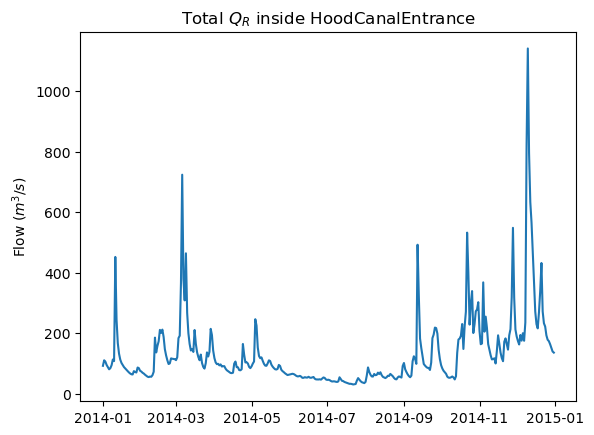

In [13]:
if len(rivers_in_cv) == 0:
    river_qs = np.zeros_like(rivers['time'][:])
else:
    rivers_idxs = np.where(np.isin(np.ma.getdata(rivers['node'][:]),
                                   list(rivers_in_cv)))[0]
    river_qs = rivers['discharge'][:,rivers_idxs].sum(axis=1)
display(river_qs.shape)
fig, ax = plt.subplots()
river_dates = pd.Timestamp(hydro_output_start) + pd.to_timedelta(rivers['time'][:], 'H')
ax.plot(river_dates, river_qs)
ax.set(ylabel='Flow ($m^3/s$)', title=f'Total $Q_R$ inside {", ".join(section_names)}')
fig.savefig(out_file('qr.png'))

In [14]:
onesect = next(iter(section_names))

# model output times are in seconds
# Get times from a section extraction since they are at a guaranteed 1-hr frequency
section_dates = pd.Timestamp('1970-01-01') + pd.to_timedelta(section_extractions[onesect]['ocean_time'][:], 's')
# Convert dates back to seconds since the start of the model run
section_output_times = ((section_dates - pd.Timestamp(section_extractions[onesect].date_string0)) /
                      np.timedelta64(1, 's')).astype(int).to_numpy()
# The output times from the model run may be at a higher frequency, but there should be overlap
model_output_times = hydro_output['time'][:]
# river times are in hours; convert them
river_times = rivers['time'][:] * 3600
# The model can potentially run past the boundary conditions, and if that
# happened we need to truncate the output
cut_indices_model = (model_output_times > river_times.max()).nonzero()[0]
if len(cut_indices_model) > 0:
    time_removed_model = (model_output_times[cut_indices_model.max()] -
                          model_output_times[cut_indices_model.min()]) / 87600
    print(f'Need to remove {time_removed_model:.2f} days of model output from end of run')
    right_cut_model = cut_indices_model.min()
    model_output_times = model_output_times[:right_cut_model]
else:
    right_cut_model = None
cut_indices_section = (section_output_times > river_times.max()).nonzero()[0]
if len(cut_indices_section) > 0:
    right_cut_section = cut_indices_section.min()
    section_output_times = section_output_times[:right_cut_section]
    section_dates = section_dates[:right_cut_section]
else:
    right_cut_section = None
rivers_interp = interp1d(river_times, river_qs)(section_output_times)
print(f't: {len(section_dates)}; QR: {len(river_times)}; Qin/out: {len(qpr_in[onesect])}')

Need to remove 1.95 days of model output from end of run
t: 8736; QR: 365; Qin/out: 8736


## Perform Volume Balance and Plot Result

In [15]:
model_dates = pd.Timestamp(hydro_output_start) + pd.to_timedelta(model_output_times[1:], 's')
model_df = pd.DataFrame({'$dV/dt$': dVdt[:right_cut_model-1]}, index=model_dates)
section_data = {}
for x in section_names:
    section_data[x + ' $Q_\mathrm{prism,in}$'] = qpr_in[x][:right_cut_section]
    section_data[x + ' $Q_\mathrm{prism,out}$'] = qpr_out[x][:right_cut_section]
section_data['$Q_R$'] = rivers_interp
vol_budget = model_df.merge(pd.DataFrame(section_data, index=section_dates), how='left', left_index=True, right_index=True)
vol_budget.dropna().tail()

,$dV/dt$,"HoodCanalEntrance $Q_\mathrm{prism,in}$","HoodCanalEntrance $Q_\mathrm{prism,out}$",$Q_R$
2014-12-30 20:00:00,51573.996987,54676.279811,-243.975608,136.215970
2014-12-30 21:00:00,63205.812463,63617.810564,-44.554562,136.063429
2014-12-30 22:00:00,68338.757723,67874.487777,-49.580412,135.910887
2014-12-30 23:00:00,70792.936259,73149.798661,-21.092867,135.758346
2014-12-31 00:00:00,56673.581770,59187.486293,-64.229495,135.605804


In [16]:
if tide_avg:
    # We have to make all the data hourly in order for the tidal averaging to work correctly
    vol_budget.dropna(inplace=True)
    for c in vol_budget.columns:
        vol_budget[c] = filt_godin(vol_budget[c].to_numpy())
    display(vol_budget.dropna().tail())

,$dV/dt$,"HoodCanalEntrance $Q_\mathrm{prism,in}$","HoodCanalEntrance $Q_\mathrm{prism,out}$",$Q_R$
2014-12-29 09:00:00,-34.305848,24346.101516,-24536.828094,146.735926
2014-12-29 10:00:00,-32.222598,24274.832123,-24463.832494,146.287003
2014-12-29 11:00:00,-29.541290,24205.920177,-24392.565309,145.844777
2014-12-29 12:00:00,-26.420631,24138.762530,-24322.580720,145.409727
2014-12-29 13:00:00,-23.028888,24072.894389,-24253.522996,144.982341


In [17]:
vol_budget['error'] = -vol_budget['$dV/dt$'] + vol_budget[vol_budget.columns[1:]].sum(1)
vol_budget.loc[vol_budget['$Q_R$'].isna(), 'error'] = np.nan
vol_budget.dropna().tail()

,$dV/dt$,"HoodCanalEntrance $Q_\mathrm{prism,in}$","HoodCanalEntrance $Q_\mathrm{prism,out}$",$Q_R$,error
2014-12-29 09:00:00,-34.305848,24346.101516,-24536.828094,146.735926,-9.684805
2014-12-29 10:00:00,-32.222598,24274.832123,-24463.832494,146.287003,-10.490771
2014-12-29 11:00:00,-29.541290,24205.920177,-24392.565309,145.844777,-11.259065
2014-12-29 12:00:00,-26.420631,24138.762530,-24322.580720,145.409727,-11.987832
2014-12-29 13:00:00,-23.028888,24072.894389,-24253.522996,144.982341,-12.617377


Error:          0.97 cms (0.73% of mean Q_R)
Error per $dV/dt$: 852.21%
RMSE:           0.11 cms (0.08% of mean Q_R)


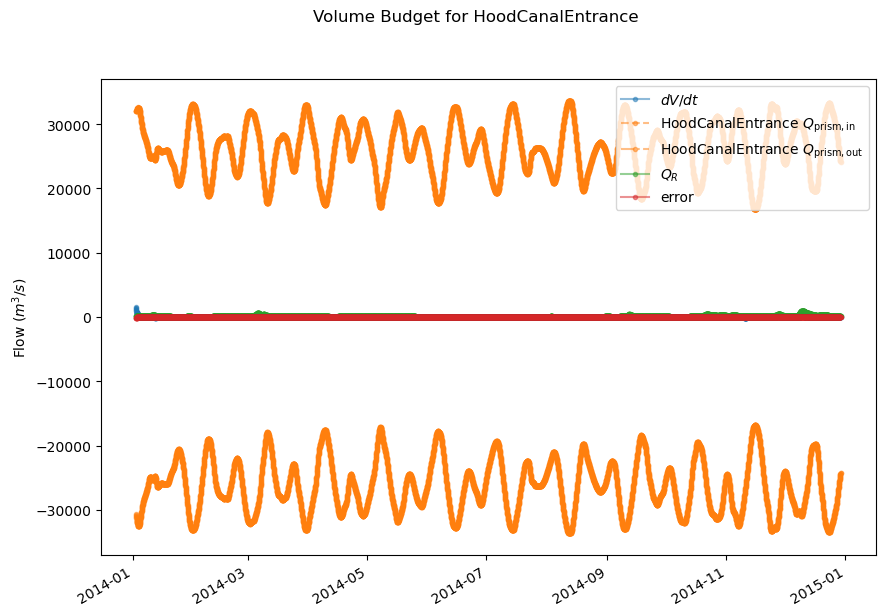

In [18]:
def plot_budget(df):
    fig, ax = plt.subplots(figsize=(10,7))
    l = None
    for c in df.columns:
        color = None
        if c[-5:-2] == 'out':
            color = l[0].get_color()
            linestyle = '.-.'
        elif c[-4:-2] == 'in':
            linestyle = '.--'
        else:
            linestyle = '.-'
        l = ax.plot(df[c].dropna(), linestyle, color=color, label=c, alpha=0.5)
    return fig, ax

fig, ax = plot_budget(vol_budget)
qr = vol_budget['$Q_R$'].dropna()
if not tide_avg:
    ax.set(xbound=(qr.index[8400], qr.index[8460]))
ax.set(ylabel="Flow ($m^3/s$)")
ax.legend()
fig.autofmt_xdate()
fig.suptitle(f'Volume Budget for {", ".join(section_names)}')
fig.savefig(out_file('vol_budget.png'))

def error_stats(df, unit, fudge=0):
    cvchg = df.columns[0]
    err_cols = [cvchg,'$Q_R$','error'] if '$Q_R$' in df.columns else [cvchg, 'error']
    error = df[err_cols].dropna()
    mean_error = error['error'][fudge:].mean()
    if '$Q_R$' in df.columns:
        error_per_qr = np.nan if error['$Q_R$'].mean() == 0 else mean_error / error['$Q_R$'].mean()
        print(f'Error:          {mean_error:.2f} {unit} ({error_per_qr * 100:.2f}% of mean Q_R)')
    else:
        print(f'Error:          {mean_error:.2f} {unit}')
    error_per_cvchg = np.abs(mean_error / error[cvchg][fudge:].mean())
    print(f'Error per {cvchg}: {error_per_cvchg*100:.2f}%')
    rmse = np.sqrt((error['error'] ** 2).sum())/len(error['error'])
    if '$Q_R$' in df.columns:
        rmse_per_qr = np.nan if error['$Q_R$'].mean() == 0 else rmse / error['$Q_R$'].mean()
        print(f'RMSE:           {rmse:.2f} {unit} ({rmse_per_qr * 100:.2f}% of mean Q_R)')
    else:
        print(f'RMSE:           {rmse:.2f} {unit}')

error_stats(vol_budget, 'cms', fudge=83)

# Salt Balance

## Calculate d(VS)/dt

First get the total volume broken down by node, layer, and time index

In [19]:
dVSdt = ndimage.gaussian_filter1d(VS, sigma=1, order=1)[1:] / np.diff(hydro_output['time'][:])
display(dVSdt.shape)
dVSdt

(17567,)

array([-1244703.60704891, -1208483.38112331, -1113344.22660516, ...,
        2299114.8962926 ,  2067719.85684311,   901174.39593375])

## Calculate salinity fluxes in and out

In [20]:
qspr_in = {}
qspr_out = {}
transect_directions = cv.transect_directions()
for s, d in zip(section_names, transect_directions):
    direction = 1 if d else -1
    ds = section_extractions[s]
    # shape becomes (s_z, xi_sect, time)
    q = np.moveaxis(ds['q'][:], 0, 2)
    salt = np.moveaxis(ds['salt'][:], 0, 2)
    # shape becomes (xi_sect, time)
    tide_adj = (1 + ds['zeta'][:] / ds['h'][:]).T
    qspr_in[s] = (np.where(q * direction > 0, q, 0) * salt * tide_adj * direction).sum(axis=(0,1))
    qspr_out[s] = (np.where(q * direction < 0, q, 0) * salt * tide_adj * direction).sum(axis=(0,1))
    display(f'qs_in {s}', qspr_in[s])
    display(f'qs_out {s}', qspr_out[s])

'qs_in HoodCanalEntrance'

masked_array(data=[0.0, 61329.714414107686, 125798.9108527712, ...,
                   2029926.5935657027, 2211426.2298618583,
                   1807928.8776193568],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+20)

'qs_out HoodCanalEntrance'

masked_array(data=[-1551690.884399748, -668570.9053551895,
                   -336530.48412216094, ..., -1335.9561622683118,
                   -573.7421098277639, -1792.1899824503148],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+20)

## Perform Salt Balance and Plot Result

In [21]:
model_salt_df = pd.DataFrame({'$d(VS)/dt$': dVSdt[:right_cut_model-1]}, index=model_dates)
salt_section_data = {}
for x in section_names:
    salt_section_data[x + ' $QS_\mathrm{prism,in}$'] = qspr_in[x][:right_cut_section]
    salt_section_data[x + ' $QS_\mathrm{prism,out}$'] = qspr_out[x][:right_cut_section]
salt_budget = model_salt_df.merge(pd.DataFrame(salt_section_data, index=section_dates),
                                  how='left', left_index=True, right_index=True)
salt_budget.dropna().tail()

,$d(VS)/dt$,"HoodCanalEntrance $QS_\mathrm{prism,in}$","HoodCanalEntrance $QS_\mathrm{prism,out}$"
2014-12-30 20:00:00,1.527442e+06,1.612453e+06,-6928.049134
2014-12-30 21:00:00,1.869022e+06,1.886714e+06,-1270.495393
2014-12-30 22:00:00,2.018793e+06,2.029927e+06,-1335.956162
2014-12-30 23:00:00,2.094723e+06,2.211426e+06,-573.742110
2014-12-31 00:00:00,1.678665e+06,1.807929e+06,-1792.189982


In [22]:
if tide_avg:
    # We have to make all the data hourly in order for the tidal averaging to work correctly
    salt_budget.dropna(inplace=True)
    for c in salt_budget.columns:
        salt_budget[c] = filt_godin(salt_budget[c].to_numpy())
    display(salt_budget.dropna().tail())

,$d(VS)/dt$,"HoodCanalEntrance $QS_\mathrm{prism,in}$","HoodCanalEntrance $QS_\mathrm{prism,out}$"
2014-12-29 09:00:00,-4275.376539,734207.771408,-738230.040641
2014-12-29 10:00:00,-4298.830393,731977.991668,-736042.023553
2014-12-29 11:00:00,-4302.725900,729821.044465,-733905.207240
2014-12-29 12:00:00,-4291.736346,727718.723133,-731806.359002
2014-12-29 13:00:00,-4270.384722,725657.268017,-729734.927008


In [23]:
salt_budget['error'] = -salt_budget['$d(VS)/dt$'] + salt_budget[salt_budget.columns[1:]].sum(1, skipna=False)
salt_budget.dropna().tail()

,$d(VS)/dt$,"HoodCanalEntrance $QS_\mathrm{prism,in}$","HoodCanalEntrance $QS_\mathrm{prism,out}$",error
2014-12-29 09:00:00,-4275.376539,734207.771408,-738230.040641,253.107305
2014-12-29 10:00:00,-4298.830393,731977.991668,-736042.023553,234.798508
2014-12-29 11:00:00,-4302.725900,729821.044465,-733905.207240,218.563126
2014-12-29 12:00:00,-4291.736346,727718.723133,-731806.359002,204.100476
2014-12-29 13:00:00,-4270.384722,725657.268017,-729734.927008,192.725731


Error:          2862.22 psu-cms
Error per $d(VS)/dt$: 2195.54%
RMSE:           43.19 psu-cms


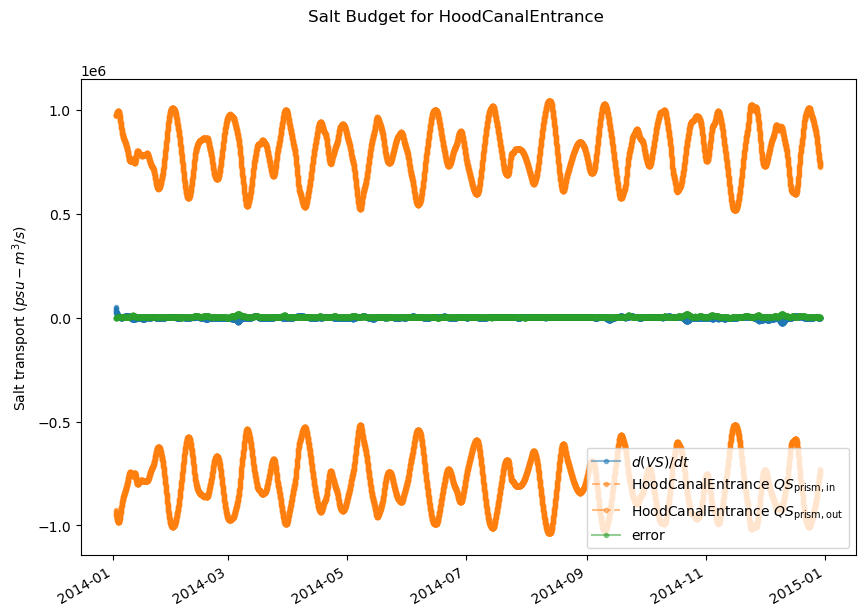

In [24]:
fig, ax = plot_budget(salt_budget)
if not tide_avg:
    ax.set(xbound=(section_dates[4400], section_dates[4460]))
ax.set(ylabel="Salt transport ($psu-m^3/s$)")
ax.legend()
fig.autofmt_xdate()
fig.suptitle(f'Salt Budget for {", ".join(section_names)}')
fig.savefig(out_file('salt_budget.png'))

error_stats(salt_budget, 'psu-cms')

# TEF Volume/Salt Budget

In [25]:
q_in = {}
q_out = {}
qs_in = {}
qs_out = {}
for s in section_names:
    with open(path.join(extracts_path, 'bulk', s + '.p'), 'rb') as f:
        bulk_result = pickle.load(f)
    qq = bulk_result['QQ']
    ss = bulk_result['SS']
    bulk_dates = pd.Timestamp('1/1/1970 00:00') + pd.to_timedelta(bulk_result['ot'].data, 'sec')
    qq_in = np.where(qq > 0, qq, 0)
    qq_out = np.where(qq < 0, qq, 0)
    q_in[s] = qq_in.sum(axis=1)
    q_out[s] = qq_out.sum(axis=1)
    qs_in[s] = np.nansum(qq_in * ss, axis=1)
    qs_out[s] = np.nansum(qq_out * ss, axis=1)
next(iter(qs_in.values())).shape

(361,)

In [26]:
model_df = pd.DataFrame({'$dV/dt$': dVdt[:right_cut_model-1]}, index=model_dates)
# Filter just the section dates (hourly) and tidally average
model_df = model_df.loc[model_df.index.isin(section_dates)].copy()
model_df['$dV/dt$'] = filt_godin(model_df['$dV/dt$'])
section_data = {}
for x in section_names:
    section_data[x + ' $Q_\mathrm{in}$']  = q_in[x]
    section_data[x + ' $Q_\mathrm{out}$'] = q_out[x]
qr_series = pd.Series(filt_godin(rivers_interp), index=section_dates, name='$Q_R$')

tef_vol_budget = (model_df.merge(pd.DataFrame(section_data, index=bulk_dates), how='left', left_index=True, right_index=True)
                  .merge(pd.DataFrame(qr_series), how='left', left_index=True, right_index=True))
tef_vol_budget['error'] = -tef_vol_budget['$dV/dt$'] + tef_vol_budget[tef_vol_budget.columns[tef_vol_budget.columns != '$dV/dt$']].sum(1)
tef_vol_budget.dropna(inplace=True)
tef_vol_budget.tail()

,$dV/dt$,HoodCanalEntrance $Q_\mathrm{in}$,HoodCanalEntrance $Q_\mathrm{out}$,$Q_R$,error
2014-12-24 13:00:00,-27.145682,7227.296677,-7467.832214,206.095396,-7.294459
2014-12-25 13:00:00,-23.224915,6657.201244,-6866.193516,185.792448,0.025091
2014-12-26 13:00:00,22.817122,7146.420018,-7280.664764,175.652460,18.590592
2014-12-27 13:00:00,71.758575,6580.486099,-6661.972282,167.599424,14.354667
2014-12-28 13:00:00,-8.334162,5388.534283,-5540.181783,156.475753,13.162414


Error:          0.61 cms (0.46% of mean Q_R)
Error per $dV/dt$: 12.78%
RMSE:           0.61 cms (0.46% of mean Q_R)


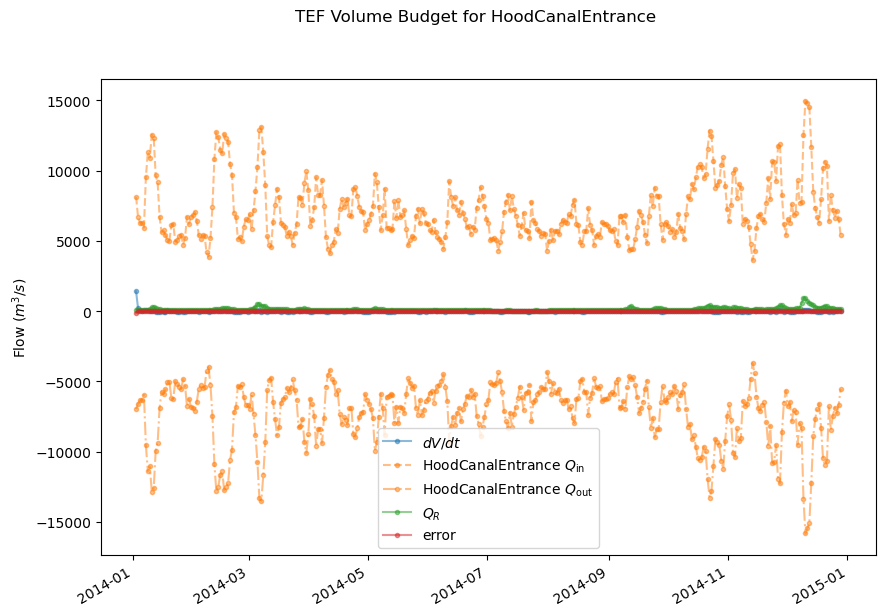

In [27]:
fig, ax = plot_budget(tef_vol_budget)
    
qr = tef_vol_budget['$Q_R$'].dropna()
#ax.set(xbound=(qr.index[8400], qr.index[8460]))
ax.set(ylabel="Flow ($m^3/s$)")
ax.legend()
fig.autofmt_xdate()
fig.suptitle(f'TEF Volume Budget for {", ".join(section_names)}')
fig.savefig(out_file('tef_vol_budget.png'))

error_stats(tef_vol_budget, 'cms')

In [28]:
model_salt_df = pd.DataFrame({'$d(VS)/dt$': dVSdt[:right_cut_model-1]}, index=model_dates)
# Subsample using section_dates to ensure hourly output before passing to filt_godin
model_salt_df.loc[model_dates.difference(section_dates), '$d(VS)/dt$'] = np.nan
model_salt_df.dropna(inplace=True)
model_salt_df['$d(VS)/dt$'] = filt_godin(model_salt_df['$d(VS)/dt$'])

salt_section_data = {}
for x in section_names:
    salt_section_data[x + ' $QS_\mathrm{in}$'] = qs_in[x]
    salt_section_data[x + ' $QS_\mathrm{out}$'] = qs_out[x]
tef_salt_budget = model_salt_df.merge(pd.DataFrame(salt_section_data, index=bulk_dates),
                                  how='left', left_index=True, right_index=True)
tef_salt_budget['error'] = -tef_salt_budget['$d(VS)/dt$'] + tef_salt_budget[tef_salt_budget.columns[1:]].sum(1)
tef_salt_budget.dropna(inplace=True)
tef_salt_budget.tail()

,$d(VS)/dt$,HoodCanalEntrance $QS_\mathrm{in}$,HoodCanalEntrance $QS_\mathrm{out}$,error
2014-12-24 13:00:00,-1994.166288,216614.483881,-217982.742730,625.907439
2014-12-25 13:00:00,-1183.561204,199543.772680,-200215.609539,511.724345
2014-12-26 13:00:00,883.405666,213788.163262,-210629.128469,2275.629127
2014-12-27 13:00:00,2081.963387,196687.315001,-191330.238230,3275.113384
2014-12-28 13:00:00,-1574.250054,160548.454819,-161048.637307,1074.067566


Error:          2364.37 psu-cms
Error per $d(VS)/dt$: 4715.73%
RMSE:           192.98 psu-cms


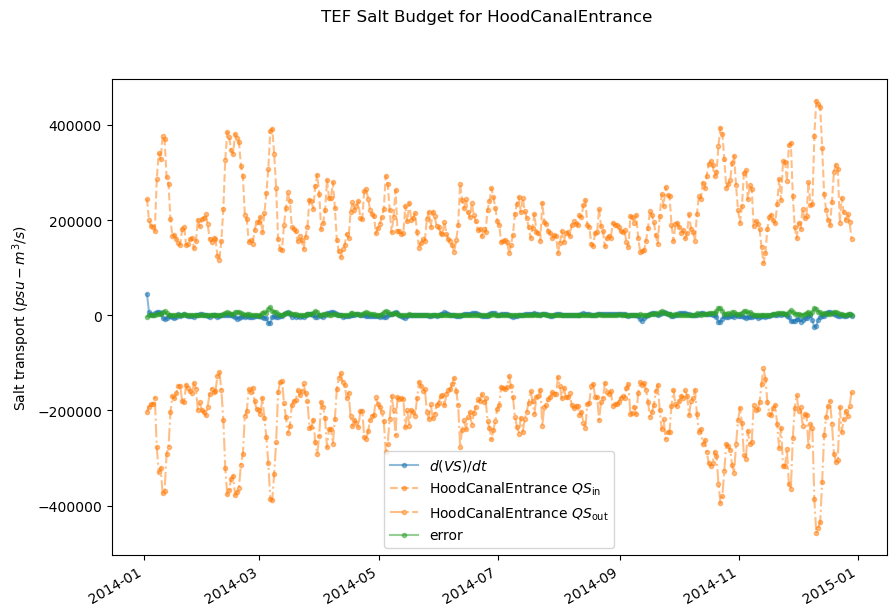

In [29]:
fig, ax = plot_budget(tef_salt_budget)
ax.set(ylabel="Salt transport ($psu-m^3/s$)")
ax.legend()
fig.autofmt_xdate()
fig.suptitle(f'TEF Salt Budget for {", ".join(section_names)}')
fig.savefig(out_file('tef_salt_budget.png'))

error_stats(tef_salt_budget, 'psu-cms')